<a href="https://colab.research.google.com/drive/1wTptldyKqQmghRS420AN7XepdNpHusOJ" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder):

> An autoencoder is a type of artificial neural network used to learn efficient codings of unlabeled data (unsupervised learning). An autoencoder learns two functions: an encoding function that transforms the input data, and a decoding function that recreates the input data from the encoded representation.

This notebook implements, in some sense, the simplest possible autoencoder: one that tries to reconstruct a higher-dimensional vector. Specifically, it converts a 100-dimensional input vector to a 10-dimensional encoding, then attempts to reconstruct the original 100-dimensional vector from the 10-dimensional encoding.

We train and test on random data, so we get absolutely awful test accuracy (~8%). But if we used more structured data, such as [MNIST images](https://en.wikipedia.org/wiki/MNIST_database), we would get much better performance &mdash; the model would have actual features to represent as directions in a lower-dimensional space, as opposed to just high-entropy random noise.

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# Define autoencoder

In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Generate random data

In [3]:
num_samples = 10000
data = torch.randn(num_samples, 100)

# Split data into train and test sets
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(TensorDataset(data), [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize model, loss function and optimizer

In [4]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)

# Test function

In [5]:
# Calculate test loss and accuracy
error_threshold = 0.1

def test(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            total_loss += loss.item() * inputs.shape[0]

            # Calculate "accuracy" as the percentage of elements reconstructed within a small threshold
            correct = torch.abs(outputs - inputs) < error_threshold
            total_correct += correct.sum().item()
            total_samples += inputs.numel()

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = (total_correct / total_samples) * 100
    return avg_loss, accuracy

# Training loop

In [6]:
# Lists to store metrics for plotting
train_losses = []
test_losses = []
test_accuracies = []

# Training loop
num_epochs = 70
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs = batch[0]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.shape[0]

    # Calculate average train loss
    avg_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Calculate test loss and accuracy
    test_loss, test_accuracy = test(model, test_loader, criterion)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/70], Train Loss: 0.9677, Test Loss: 0.9299, Test Accuracy: 8.20%
Epoch [2/70], Train Loss: 0.9121, Test Loss: 0.9112, Test Accuracy: 8.32%
Epoch [3/70], Train Loss: 0.9021, Test Loss: 0.9081, Test Accuracy: 8.36%
Epoch [4/70], Train Loss: 0.8980, Test Loss: 0.9066, Test Accuracy: 8.27%
Epoch [5/70], Train Loss: 0.8951, Test Loss: 0.9052, Test Accuracy: 8.33%
Epoch [6/70], Train Loss: 0.8931, Test Loss: 0.9047, Test Accuracy: 8.35%
Epoch [7/70], Train Loss: 0.8912, Test Loss: 0.9040, Test Accuracy: 8.33%
Epoch [8/70], Train Loss: 0.8896, Test Loss: 0.9036, Test Accuracy: 8.34%
Epoch [9/70], Train Loss: 0.8882, Test Loss: 0.9031, Test Accuracy: 8.42%
Epoch [10/70], Train Loss: 0.8868, Test Loss: 0.9026, Test Accuracy: 8.49%
Epoch [11/70], Train Loss: 0.8855, Test Loss: 0.9021, Test Accuracy: 8.44%
Epoch [12/70], Train Loss: 0.8842, Test Loss: 0.9015, Test Accuracy: 8.45%
Epoch [13/70], Train Loss: 0.8829, Test Loss: 0.9013, Test Accuracy: 8.51%
Epoch [14/70], Train Loss: 0.8818,

# Plotting

## How to interpret these plots

We can see that training loss goes down over time, while test loss and test accuracy barely budge. This is to be expected: the training dataset remains the same, but the test dataset is randomly generated noise each time. That is to say, there *are* no patterns between training data and test data for the model to learn.

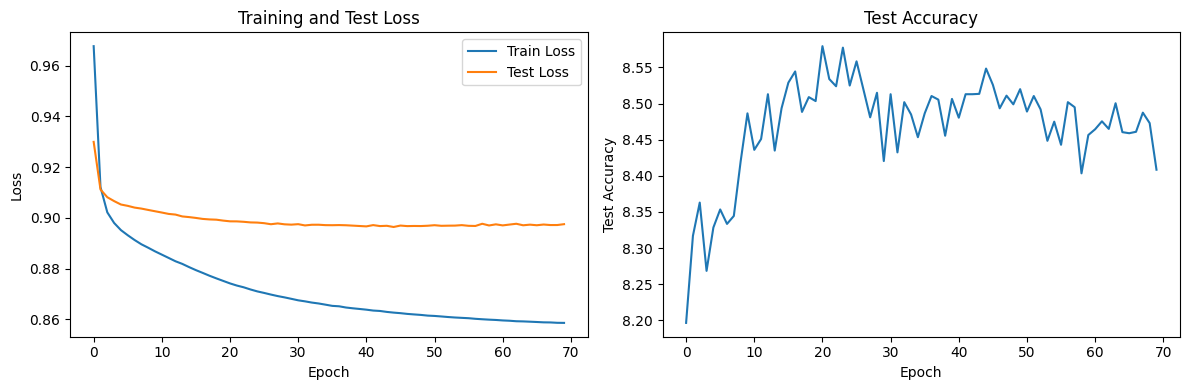

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy')

plt.tight_layout()
plt.show()

# Testing the autoencoder

In [8]:
test_input = torch.randn(1, 100)
encoded = model.encoder(test_input)
decoded = model(test_input)

# Size checks
print("Original size:", test_input.size())
print("Encoded size:", encoded.size())
print("Decoded size:", decoded.size())

# Calculate and display reconstruction error
reconstruction_error = criterion(decoded, test_input)
print(f"Reconstruction mean-squared error: {reconstruction_error.item():.4f}")

Original size: torch.Size([1, 100])
Encoded size: torch.Size([1, 10])
Decoded size: torch.Size([1, 100])
Reconstruction mean-squared error: 0.8820
